In [1]:
from Config import Config
import os
import pandas as pd
from data_utils import clean_text, stem_text
import pytz # "Europe/Minsk" in pytz.all_timezones

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ishitagopal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ishitagopal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import multiprocessing as mp
p = mp.Pool(mp.cpu_count()-1) # Data parallelism Object

In [3]:
pd.set_option('display.max_rows', None)

In [4]:
f_dir = os.path.join(
    Config.proccessed_data_dir,
    Config.chat_data_subsets_subdir,
    Config.analysis_data_file,
)


df = pd.read_csv(f_dir)
# 51.2% of the messages are replies 

/var/folders/ht/m3lhbch97rbfp8h0sn087g240000gn/T/ipykernel_23202/3360648330.py:8: DtypeWarning: Columns (24,25,26,27,28,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f_dir)


In [7]:
# convert to minsk time

df.date = p.map(pd.to_datetime, df.date) 

In [8]:
df["date_minsk"] = df.date.dt.tz_convert('Europe/Minsk').dt.strftime("%Y-%m-%d")
df["date_minsk"] = pd.to_datetime(df.date_minsk)

In [11]:
chat_f_name

'../processed_data/chat_names.csv'

In [12]:
chat_f_name = os.path.join("../data",'chat_names.csv') # 
chat_names = pd.read_csv(chat_f_name, usecols=["chat_name", "region"])
df = df.merge(chat_names, on="chat_name", how="left")

In [13]:
#df_3 = df[df.chat_name != "majakrainablr"]
data = df.loc[df.date_minsk > pd.to_datetime("2020-09-14")]


<AxesSubplot:ylabel='Prop of messages'>

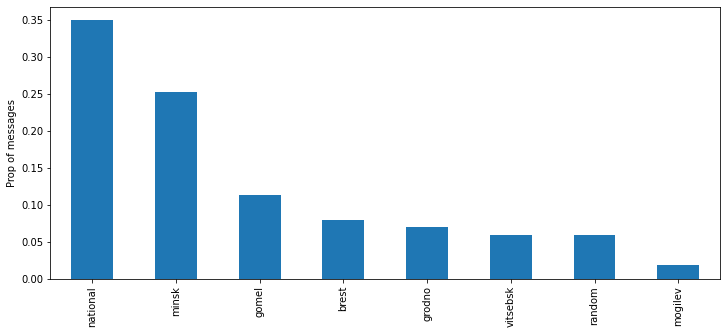

In [14]:
# Number of posts across different regions 
data["region"].value_counts(normalize=True, dropna=False).plot(kind="bar", ylabel="Prop of messages",figsize=(12,5))

<AxesSubplot:ylabel='Prop of messages'>

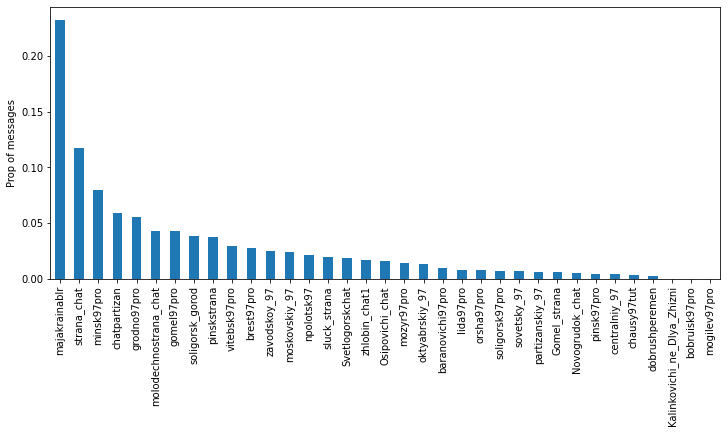

In [ ]:
# 
data.chat_name.value_counts(normalize=True).plot(kind="bar", ylabel="Prop of messages",figsize=(12,5))

<AxesSubplot:ylabel='Prop of messages'>

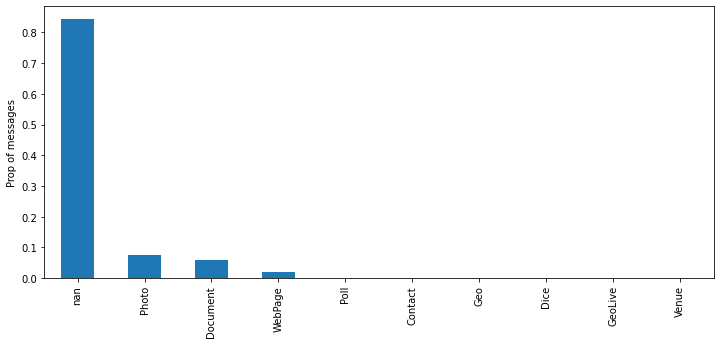

In [15]:
# media used 
(
    data
    .media_type
    .value_counts(normalize=True, dropna=False)
    .plot(kind="bar", ylabel="Prop of messages",figsize=(12,5)))

In [16]:
# there are 136938 unique users --> 80774 unique users starting 2020-09-16 
data.from_user_id.nunique()

80774

In [17]:
# remove messages that are NAs/ dont have text  
data_2 = data[data.message.isna()==False].reset_index(drop=True)
print(data_2.shape)


(1092790, 35)


In [18]:
#df_3.date_minsk.min()
#There are 68391 unique users starting 2020-09-16 who have posted a message with text
data
data_2.from_user_id.nunique()

68391

In [19]:
# the max number of messages is 10385 --> 10% of the messages are from 1 user
# 50% of the users have posted less than 3 messages
data_2.groupby(["from_user_id"])["id"].count().sort_values(ascending=False).describe()

count    68391.000000
mean        15.746034
std         91.916254
min          1.000000
25%          1.000000
50%          3.000000
75%          9.000000
max      10385.000000
Name: id, dtype: float64

<AxesSubplot:xlabel='Region', ylabel='Number of unique users'>

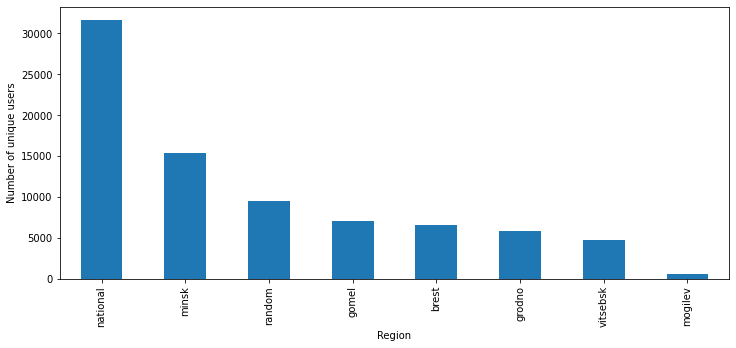

In [20]:
# Number of unique users who posted in each region
(data_2
.groupby("region")
.from_user_id.nunique()
.sort_values(ascending=False)
.plot(kind="bar", xlabel="Region", ylabel="Number of unique users",figsize=(12,5)))

# Analyze the text of messages 

In [22]:
import time
# clean text 
# parallelize the cleaning
p = mp.Pool(mp.cpu_count()-1) # Data parallelism Object
start_time  = time.time()
data_2["stemmed_clean_text"] = p.map(clean_text, data_2["message"]) 
print(time.time() - start_time)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ishitagopal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ishitagopal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ishitagopal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ishitagopal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ishitagopal/nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ishitagopal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ishitagopal/nltk_data...
[nltk_data]   Packa

317.86545062065125


In [23]:
# example of cleaned text 
data_2["stemmed_clean_text"][1800], data_2["message"][1800]

('жыв белар', 'Жыве Беларусь.')

In [24]:
# Convert a collection of text documents to a matrix of token counts.
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np


# create dtm 
vectorizer = CountVectorizer(max_df= 0.90, min_df = 500)
dtm=vectorizer.fit_transform(data_2['stemmed_clean_text'])

# sparsity
1.0 - float(dtm.size) / np.prod(dtm.shape) # About 98% zeros

# vocab
vocab = vectorizer.get_feature_names_out()
len(vocab)

# Get a sorted list of word frequencies (column sums of the dtm):
sum_words = dtm.sum(axis=0) # a 1x3659 matrix
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)


In [94]:
# # Save the top 50 words to a csv file
# pd.set_option('display.max_columns', None)
# top_50_words = pd.DataFrame(words_freq[:50], columns=["word", "freq"])
# top_50_words.to_csv(os.path.join(Config.proccessed_data_dir, "top_50_words.csv"), index=False)

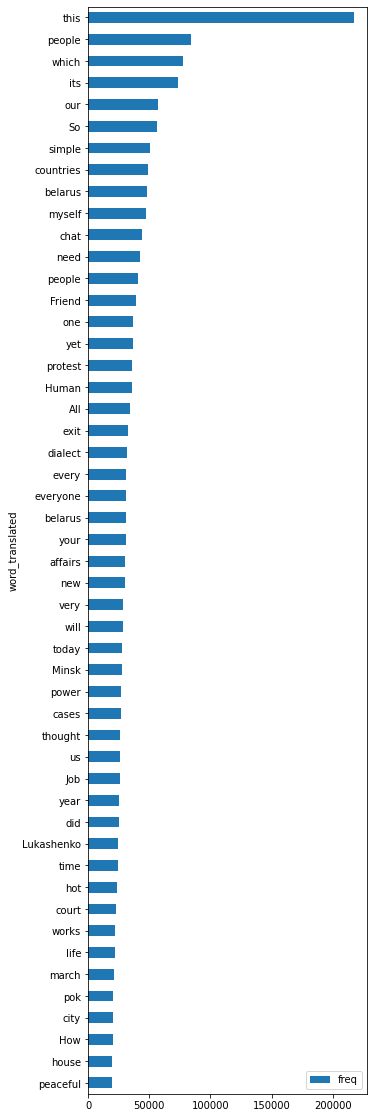

In [164]:
# Plot translation of the top 50 words
top_50_words = pd.read_excel(os.path.join(Config.proccessed_data_dir, "chat_analysis_results/frequent_words/top_50_words.xlsx"))
top_50_words.plot(kind="barh", x="word_translated", y="freq", figsize=(5, 20)).invert_yaxis()

In [60]:
# function to list the emojis in string
import emoji
def Emoji_list(text):
    emoji_list = []
    for char in text:
        if char in emoji.EMOJI_DATA.keys():
            emoji_list.append(char)
    return ' '.join(emoji_list)


In [69]:
# emoji list 
data_2["emojis"] = data_2["message"].apply(Emoji_list)

emoji_vectorizer=CountVectorizer(token_pattern=r'[^\s]+')
emoji_dtm=emoji_vectorizer.fit_transform(data_2["emojis"])

# emoji vocab
emoji_vocab = emoji_vectorizer.get_feature_names_out()
len(emoji_vocab)
#emoji_vectorizer.get_feature_names_out()[:20]

# Get a sorted list of word frequencies (column sums of the dtm):
sum_emojis = emoji_dtm.sum(axis=0) # a 1x3659 matrix
emoji_freq = [(emoji, sum_emojis[0, idx]) for emoji, idx in emoji_vectorizer.vocabulary_.items()]
emoji_freq = sorted(emoji_freq, key = lambda x: x[1], reverse=True)

In [161]:
emoji_counts = pd.DataFrame(emoji_freq, columns=["emoji", "count"])
emoji_counts["perc"] = round((emoji_counts["count"]/emoji_counts["count"].sum())*100, 2)

In [163]:
emoji_counts[["emoji", "perc"]].head(10)

,emoji,perc
0,👍,12.40
1,😂,8.89
2,❤,5.64
3,⚡,4.38
4,✌,3.85
5,👇,3.84
6,‼,3.44
7,✊,3.40
8,🤣,2.87
9,❗,2.84


In [97]:
# save cleaned dataframe
f_dir = os.path.join(
    Config.proccessed_data_dir,
    Config.chat_data_subsets_subdir)

data_2.to_csv(os.path.join(f_dir, "cleaned_msg_Aug_Mar.csv"), index=False)

In [13]:


# subset messages which are replies
cols = ["id","message", "reply_to_msg_id", "chat_name", "is_reply"]
replies = df_2.loc[df_2.reply_to_msg_id.isna()==False, cols].reset_index(drop=True)
replies["reply_to_msg_id"] = replies["reply_to_msg_id"].astype(int).astype(str) # convert to string
replies.message = replies.message.astype(str) # convert to string
replies["unique_reply_to_msg_id"] = replies.chat_name + "_" + replies.reply_to_msg_id # create unique reply ids 
replies.sort_values(by=["chat_name", "id"], inplace=True) # sort by ascending order
print(replies.shape)

# subset messages which are not replies
messages = df_2[df_2.reply_to_msg_id.isna()==True].reset_index(drop=True)
print(messages.shape)

(2071981, 35)
(1156065, 6)
(915916, 35)


In [ ]:
# Chats between Aman and Sapna
# Total Messages:  1288
# Number of Media Shared:  11
# Number of Emojis Shared 367
# Number of Links Shared 1

# import re
# import regex
# import numpy as np
# URLPATTERN = r'(https?://\S+)'
# df_2['urlcount'] = df_2.Message.apply(lambda x: regex.findall(URLPATTERN, x)).str.len()
# links = np.sum(df.urlcount)


In [179]:
# date 
df_2["date"] = pd.to_datetime(df_2["date"]).dt.date

In [184]:
daily_msgs = df_2.groupby("date").id.count().reset_index(name="num_msgs")
daily_msgs[daily_msgs.num_msgs == daily_msgs.num_msgs.max()]

,date,num_msgs
3,2020-08-12,115959


In [173]:
# make threads 
reply_threads = (
    replies
    .groupby('unique_reply_to_msg_id')['message']
    .agg('\n'.join)
    .reset_index(name="all_replies",drop=False)
)

# merge threads with messages
threads = (
    messages
    .merge(reply_threads, how="left", left_on="unique_msg_id", right_on="unique_reply_to_msg_id"))


In [174]:
threads

,Unnamed: 0,id,date,message,from_id,fwd_from,reply_to,media,entities,views,forwards,edit_date,ttl_period,has_from_id,is_fwd,is_reply,is_media,has_entity,from_user_id,media_type,fwd_type,fwd_id,reply_to_msg_id,msg_textUrls,fwd_username,fwd_title,fwd_user_created,fwd_is_verified,fwd_is_broadcast,fwd_is_megagroup,fwd_is_gigagroup,chat_name,unique_msg_id,unique_reply_to_msg_id,all_replies
0,2,163577,2020-08-12 19:16:36+00:00,На риге тишина но где то рядом с бульваром гро...,"{'_': 'PeerUser', 'user_id': 1356124051}",NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,True,False,False,False,True,1.356124e+09,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,strana_chat,strana_chat_163577,NaN,NaN
1,3,163576,2020-08-12 19:16:36+00:00,На советском районе есть что?,"{'_': 'PeerUser', 'user_id': 1148793793}",NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,True,False,False,False,True,1.148794e+09,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,strana_chat,strana_chat_163576,NaN,NaN
2,4,163575,2020-08-12 19:16:29+00:00,https://www.youtube.com/watch?v=-vbnfNBMXgQ,"{'_': 'PeerUser', 'user_id': 438445732}",NaN,NaN,"{'_': 'MessageMediaWebPage', 'webpage': {'_': ...","[{'_': 'MessageEntityUrl', 'offset': 0, 'lengt...",NaN,NaN,NaN,NaN,True,False,False,True,True,4.384457e+08,WebPage,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,strana_chat,strana_chat_163575,NaN,NaN
3,5,163573,2020-08-12 19:16:17+00:00,Чат сайта Кобрин для жизни захвачен чужими КГБ,"{'_': 'PeerUser', 'user_id': 1223748471}",NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,True,False,False,False,True,1.223748e+09,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,strana_chat,strana_chat_163573,NaN,NaN
4,6,163572,2020-08-12 19:16:11+00:00,Дайте координацию по Бресту,"{'_': 'PeerUser', 'user_id': 165561418}",NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,True,False,False,False,True,1.655614e+08,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,strana_chat,strana_chat_163572,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915911,585902,1022031,2020-09-01 07:53:21+00:00,"Лавров заявил, что предложенная Лукашенко конс...","{'_': 'PeerUser', 'user_id': 927441416}",NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,True,False,False,False,True,9.274414e+08,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,majakrainablr,majakrainablr_1022031,majakrainablr_1022031,"Пытаются сделать вид что чем-то заняты, это мы..."
915912,585903,1022030,2020-09-01 07:53:09+00:00,"Интересно, куда Колька пошёл на 1 сентября?","{'_': 'PeerUser', 'user_id': 1371663120}",NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,True,False,False,False,True,1.371663e+09,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,majakrainablr,majakrainablr_1022030,majakrainablr_1022030,"С автоматом страну защищать от ""расшатываний"" ..."
915913,585905,1022028,2020-09-01 07:52:33+00:00,"Я думал опера не в политеке,у них и так работы...","{'_': 'PeerUser', 'user_id': 1074657775}",NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,True,False,False,False,True,1.074658e+09,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,majakrainablr,majakrainablr_1022028,NaN,NaN
915914,585915,1022016,2020-09-01 07:44:30+00:00,Учителя в Гомеле и Новополоцке поддержали Всеб...,"{'_': 'PeerUser', 'user_id': 1284397318}",NaN,NaN,"{'_': 'MessageMediaPhoto', 'photo': {'_': 'Pho...",[],NaN,NaN,NaN,NaN,True,False,False,True,True,1.284397e+09,Photo,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,majakrainablr,majakrainablr_1022016,NaN,NaN


In [170]:
pd.set_option('display.max_columns', None)
threads.loc[915911]["message"]

'Лавров заявил, что предложенная Лукашенко конституционная реформа будет оптимальной платформой для диалога.\n\nЯвно стараются сделать одну конституцию на 2 страны...'

In [176]:
threads.loc[915912]["all_replies"]

'С автоматом страну защищать от "расшатываний" и "дестабилизации")))))\nЯ думаю к нему сами придут.. ведь учиться в заведении ему небезопасно..\nОн в Барановичах с папой'

In [129]:
# number of replies per message
replies_per_message = (replies
.groupby("unique_reply_to_msg_id")["message"]
.count()
.reset_index(name="num_replies"))

<AxesSubplot:ylabel='Frequency'>

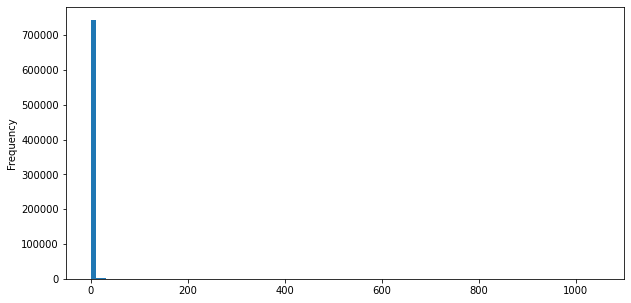

In [130]:
(replies_per_message
.num_replies
.plot(kind="hist", bins=100, figsize=(10,5))
)

In [131]:
# make boxplot of number of replies per message
replies_per_message.num_replies.describe()

count    748852.000000
mean          1.591764
std           4.463039
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max        1047.000000
Name: num_replies, dtype: float64

In [132]:
# make threads
reply_threads = (
    replies
    .groupby('unique_reply_to_msg_id')['message']
    .agg(' '.join)
    .reset_index(name="msg_replies",drop=False)
)

In [133]:
print(reply_threads.shape)
reply_threads.head()

(748852, 2)


,unique_reply_to_msg_id,msg_replies
0,Gomel_strana_26741,Я
1,Gomel_strana_40887,Интернет тормозит дико((
2,Gomel_strana_41111,https://t.me/proxy?server=well.well.well.im.he...
3,Gomel_strana_41346,У него все в порядке с головой?)
4,Gomel_strana_41349,Скорее штампуют))


In [135]:
threads.columns

Index(['Unnamed: 0', 'id', 'date', 'message', 'from_id', 'fwd_from',
       'reply_to', 'media', 'entities', 'views', 'forwards', 'edit_date',
       'ttl_period', 'has_from_id', 'is_fwd', 'is_reply', 'is_media',
       'has_entity', 'from_user_id', 'media_type', 'fwd_type', 'fwd_id',
       'reply_to_msg_id', 'msg_textUrls', 'fwd_username', 'fwd_title',
       'fwd_user_created', 'fwd_is_verified', 'fwd_is_broadcast',
       'fwd_is_megagroup', 'fwd_is_gigagroup', 'chat_name', 'unique_msg_id',
       'unique_reply_to_msg_id', 'msg_replies'],
      dtype='object')

In [136]:
threads['msg_with_replies'] = threads[["message", "msg_replies"]].fillna('').sum(axis=1)

In [137]:
threads["thread_len"] = threads.msg_with_replies.str.len()

<AxesSubplot:ylabel='Frequency'>

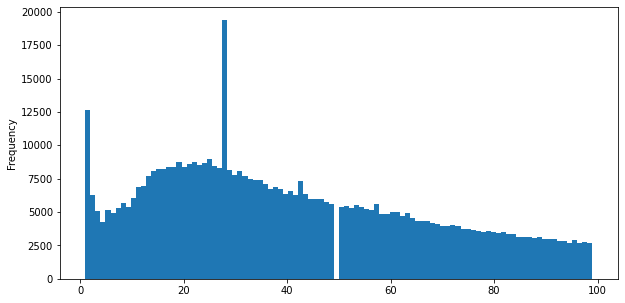

In [143]:
threads[threads["thread_len"]<100]["thread_len"].plot(kind="hist", bins=100, figsize=(10,5))

In [122]:
media = 

33              NaN
34              NaN
39              NaN
42              NaN
45              NaN
             ...   
2324183       Photo
2324188    Document
2324193         NaN
2324196         NaN
2324198    Document
Name: media_type, Length: 252230, dtype: object

In [75]:
reply_threads.shape

(748852, 2)

In [53]:
threads.columns

Index(['Unnamed: 0', 'id', 'date', 'message', 'from_id', 'fwd_from',
       'reply_to', 'media', 'entities', 'views', 'forwards', 'edit_date',
       'ttl_period', 'has_from_id', 'is_fwd', 'is_reply', 'is_media',
       'has_entity', 'from_user_id', 'media_type', 'fwd_type', 'fwd_id',
       'reply_to_msg_id', 'msg_textUrls', 'fwd_username', 'fwd_title',
       'fwd_user_created', 'fwd_is_verified', 'fwd_is_broadcast',
       'fwd_is_megagroup', 'fwd_is_gigagroup', 'chat_name', 'unique_msg_id',
       'unique_reply_to_msg_id', 'msg_replies'],
      dtype='object')

In [55]:
df.loc.groupby(["chat_name","reply_to_msg_id"])["is_reply"].count()

chat_name    reply_to_msg_id
strana_chat  161980.0           1
             162406.0           1
             162422.0           1
             162430.0           1
             162431.0           3
             162601.0           1
             162706.0           1
             162742.0           1
             162806.0           1
             163114.0           1
             163339.0           1
             163437.0           1
             163438.0           2
             163441.0           1
             163442.0           2
             163444.0           1
             163452.0           1
             163457.0           1
             163458.0           1
             163459.0           3
             163460.0           1
             163463.0           1
             163468.0           1
             163480.0           1
             163481.0           1
             163483.0           1
             163487.0           1
             163497.0           1
             163498

<AxesSubplot:ylabel='Frequency'>

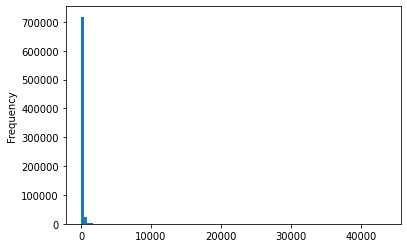

In [46]:

reply_threads.message.str.len().plot(kind='hist', bins=100)

In [47]:
reply_threads["thread_len"] = reply_threads.message.str.len()

In [53]:
import numpy as np
np.median(reply_threads["thread_len"])

61.0

In [51]:
 pd.set_option('display.max_colwidth', None)

In [49]:
longest = reply_threads.loc[reply_threads.thread_len == max(reply_threads.thread_len)]

In [57]:
main_messages.loc[main_messages.unique_msg_id == "chatpartizan_42525"]

335778    2020-10-27 20:01:29+00:00
Name: date, dtype: object

In [82]:
large = reply_threads.loc[reply_threads["thread_len"] >= 100,]

In [72]:
large = large.reset_index()

<AxesSubplot:ylabel='Frequency'>

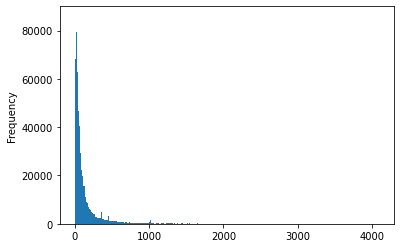

In [95]:
main_messages.message.str.len().plot(kind='hist', bins=500)

In [94]:
main_messages.message[103]

'Кратко:\n1) Парализовать жизнь в стране:\nНеобходимо поддерживать революцию главной новостью страны. Также это вовлечет всех людей в движение. Лучшее средство - перекрывать дороги повсюду.\n2) Сохранить ненасильственность!\nПотому что если бить силовиков, то им не будет времени принять решение перейти на сторону народа. Уроды среди них есть, но их меньшинство;\n3) Столкновения выгодны Лукашенко!\nСтолкновения лишь дают повод использовать силу и удерживают большинство людей от выхода на улицу (запугивают массы);\n4) Обходите!\nНет никакого смысла в том, чтобы уперто стоять перед ОМОНОМ. Когда уходишь от них, обходишь, то к протесту присоединяется больше людей, т.к. видят, что это безопасно, кроме того ОМОН изматывается преследовать людей. Когда на одной улице будет 100 тыс. человек, тогда ОМОН сам не сунется;\n5) Децентрализация!\nОмону гораздо сложнее работать сразу по всему городу, чем концентрироваться на какой-то точке. Перекрывайте улицы по всей стране, тогда не надо идти на работ

In [96]:
merge_replies = pd.merge(main_messages, reply_threads, how='left', left_on='unique_msg_id', right_on='unique_reply_to_msg_id')

In [98]:
merge_replies.head()

,Unnamed: 0,id,date,message_x,from_id,fwd_from,reply_to,media,entities,views,...,fwd_user_created,fwd_is_verified,fwd_is_broadcast,fwd_is_megagroup,fwd_is_gigagroup,chat_name,unique_msg_id,unique_reply_to_msg_id,message_y,thread_len
0,2,163577,2020-08-12 19:16:36+00:00,На риге тишина но где то рядом с бульваром громко капец,"{'_': 'PeerUser', 'user_id': 1356124051}",NaN,NaN,NaN,[],NaN,...,NaN,NaN,NaN,NaN,NaN,strana_chat,strana_chat_163577,NaN,NaN,NaN
1,3,163576,2020-08-12 19:16:36+00:00,На советском районе есть что?,"{'_': 'PeerUser', 'user_id': 1148793793}",NaN,NaN,NaN,[],NaN,...,NaN,NaN,NaN,NaN,NaN,strana_chat,strana_chat_163576,NaN,NaN,NaN
2,4,163575,2020-08-12 19:16:29+00:00,https://www.youtube.com/watch?v=-vbnfNBMXgQ,"{'_': 'PeerUser', 'user_id': 438445732}",NaN,NaN,"{'_': 'MessageMediaWebPage', 'webpage': {'_': 'WebPage', 'id': 1503448449793984905, 'url': 'https://www.youtube.com/watch?v=-vbnfNBMXgQ', 'display_url': 'youtube.com/watch?v=-vbnfNBMXgQ', 'hash': 0, 'type': 'video', 'site_name': 'YouTube', 'title': 'ДАЙ ДАРОГУ! - Баю-Бай (2020) ENG SUBS', 'description': 'Дай Дарогу! - ""Баю-Бай"" - Клип из нового альбома ""Под вой собак"" (2020)\nНовый альбом по ссылке: https://band.link/HT96X\nСобытиям Беларуси 1994-2020 посвящается. \n#дайдарогу #стыльский\n\nТекст песни:\n20 лет на автозаке, я тот самый мент\nБабки зэки и калеки - вот мой контингент\nВся парадка в медальонах, есть и ордена,\nя по части воспитания превзошёл себя\nОткрываю двери шире, заходи не сцы \nТы, говно, сейчас поймёшь, кто я здесь, а кто ты \nПоясню на роднай мове, кабы ты допер\n Хто здесь парушальник, наркоман и саботер\n \nТы кахаеш родны край ну тады и адгрыбай\nКали мил шаноуны кут, пракуроры цябе ждут \nЭй, свядомы, запевай калыханку Баю-Бай\n\nМедкомиссия в поряде - вот мой аргумент \nЯ психически стабильный, супер-мега-мент \nКак мессия для заблудших, Батин правый перст \nПотушу любую сходку и любой протест\nПредугадывать приказы наш фамильный дар\nТолько смена власти мой единственный кошмар\nКали раптам перамены я заужды гатоу\nНасыпайце грошы - атуцюжу и сяброу\n\nТы кахаеш родны край, ну тады и адгрыбай\nКали мил шаноуны кут, пракуроры цябе ждут \nЭй свядомы запевай калыханку Баю-Бай\n\nБомжа привёз - десятка \nЗа алкаша - двадцатка \nЗа бабку с бело-красно-белым флагом - 100 рублей\nПорвал пикет с докладом - 150 к окладу \nА полный автозак набил и на душе светлей', 'photo': {'_': 'Photo', 'id': 5808949105156795254, 'access_hash': -9065642532176028946, 'file_reference': ""b'\\x00b\\xd7\\x96\\xb2q\\xe1\\x89\\xfd\\xd3~\\x05kG\\xdb\\xd3\\xad\\xe2\\xdf\\xbe\\x07'"", 'date': '2020-07-18 19:04:12+00:00', 'sizes': [{'_': 'PhotoStrippedSize', 'type': 'i', 'bytes': 'b\'\\x01\\x17(\\xcf\\x11F\\xeeB\\xf0GA\\x9e\\xb4\\xf6\\xb6Dm\\xac9\\xf64\\x98\\x1d{\\xd5\\xa8\\n\\x10\\xc1\\xf0\\xab\\x8e\\x063\\xcd+\\xab\\r""\\xa9\\x85=?Z_!08?\\x9d^\\xf3-\\x95\\xd8l\\x04\\x11\\xc1\\xc7\\x14\\xe0\\xd02\\x8c\\xaa.\\x08\\xe8:\\x8a\\x93{r\\xad\\x8c\\xf3n\\x9cq\\xfa\\xd1V\\xe6\\x91<\\xb5\\xd9\\x82r\\xd9\\xf6\\xf4\\xa2\\x839Z\\xe6p\\x98z\\x1ap\\xb8\\x03\\xb1\\xa2\\x8a\\xab\\x10\\x98}\\xa0v\\x06\\x97\\xed+\\xdc\\x1a(\\xa2\\xc0\\xe4\\xd8\\x1b\\x84\\xf44QE\\x16\\x0b\\x9f\''}, {'_': 'PhotoSize', 'type': 'm', 'w': 320, 'h': 180, 'size': 19769}, {'_': 'PhotoSize', 'type': 'x', 'w': 800, 'h': 450, 'size': 88393}, {'_': 'PhotoSize', 'type': 'y', 'w': 1280, 'h': 720, 'size': 128538}], 'dc_id': 4, 'has_stickers': False, 'video_sizes': []}, 'embed_url': 'https://www.youtube.com/embed/-vbnfNBMXgQ', 'embed_type': 'iframe', 'embed_width': 1280, 'embed_height': 720, 'duration': None, 'author': None, 'document': None, 'cached_page': None, 'attributes': []}}","[{'_': 'MessageEntityUrl', 'offset': 0, 'length': 43}]",NaN,...,NaN,NaN,NaN,NaN,NaN,strana_chat,strana_chat_163575,NaN,NaN,NaN
3,5,163573,2020-08-12 19:16:17+00:00,Чат сайта Кобрин для жизни захвачен чужими КГБ,"{'_': 'PeerUser', 'user_id': 1223748471}",NaN,NaN,NaN,[],NaN,...,NaN,NaN,NaN,NaN,NaN,strana_chat,strana_chat_163573,NaN,NaN

In [ ]:
()